In [1]:
# Download and unzip dataset
!pip install kaggle timm --quiet

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!mkdir -p /content/drive/MyDrive/BrainTumorProject/Data/
!unzip -q brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/BrainTumorProject/Data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:00<00:00, 1.56GB/s]
100% 149M/149M [00:00<00:00, 1.55GB/s]


In [2]:
# image transforms
import os
from torchvision import transforms
from PIL import Image

train_dir = '/content/drive/MyDrive/BrainTumorProject/Data/Training'
test_dir  = '/content/drive/MyDrive/BrainTumorProject/Data/Testing'

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomAffine(degrees=0, scale=(0.8,1.2), shear=15),
    transforms.ToTensor(),  # scales to [0,1]
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# quick check classes
classes = sorted(os.listdir(train_dir))
print("Detected classes:", classes)

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts  = count_images_per_class(test_dir)

print("Training set image counts:")
for cls, count in train_counts.items():
    print(f"  {cls}: {count} images")

print("\nTesting set image counts:")
for cls, count in test_counts.items():
    print(f"  {cls}: {count} images")

print(f"\nTotal training images: {sum(train_counts.values())}")
print(f"Total testing images:  {sum(test_counts.values())}")

Training set image counts:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images

Testing set image counts:
  glioma: 300 images
  meningioma: 306 images
  notumor: 405 images
  pituitary: 300 images

Total training images: 5712
Total testing images:  1311


In [4]:
# gather image paths and labels, then do a single train/val split
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")  # quiet common warnings

valid_ext = {'.jpg', '.jpeg', '.png'}
image_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    for p in glob.glob(os.path.join(cls_dir, '*')):
        if os.path.splitext(p)[1].lower() in valid_ext:
            image_paths.append(p)
            labels.append(classes.index(cls))
print("Total train images found:", len(image_paths))

# single train/val split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=np.array(labels)
)

print("Train/Val split sizes:", len(train_paths), len(val_paths))

# quick dataset class (used later)
class BrainTumorDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# example dataloaders (not mandatory; train function will create its own)
train_ds = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
val_ds   = BrainTumorDataset(val_paths, val_labels, transform=val_transform)
print("Datasets ready. Train/Val sizes:", len(train_ds), len(val_ds))

Total train images found: 5712
Train/Val split sizes: 5140 572
Datasets ready. Train/Val sizes: 5140 572


In [5]:
# show class counts in the single split
from collections import Counter

tr_counts = Counter(train_labels)
va_counts = Counter(val_labels)

print("Train class counts:")
for k,v in tr_counts.items():
    print(f"  {classes[k]}: {v}")

print("Val class counts:")
for k,v in va_counts.items():
    print(f"  {classes[k]}: {v}")

Train class counts:
  pituitary: 1311
  meningioma: 1205
  notumor: 1435
  glioma: 1189
Val class counts:
  notumor: 160
  glioma: 132
  meningioma: 134
  pituitary: 146


In [6]:
# reproducibility and save split indices
import random, numpy as np, torch, json, os
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

save_path = '/content/drive/MyDrive/BrainTumorProject/Data/split_indices.json'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_dict = {
    "train_paths": train_paths,
    "val_paths": val_paths,
    "train_labels": train_labels,
    "val_labels": val_labels
}
with open(save_path, 'w') as f:
    json.dump(save_dict, f)
print("Saved split to", save_path)

Saved split to /content/drive/MyDrive/BrainTumorProject/Data/split_indices.json


In [7]:
# CNN model
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=len(classes)).to(device)
print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model params: 14871844


In [8]:
# EfficientNet-B7 instantiation
import timm, torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_effnet = timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=len(classes)).to(device)
print("EffNet-B7 params:", sum(p.numel() for p in model_effnet.parameters() if p.requires_grad))

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

EffNet-B7 params: 63797204


In [9]:
# Swin transformer
import timm, torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    model_swin = timm.create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=len(classes))
except Exception:
    model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(classes))
model_swin = model_swin.to(device)
print("Swin params:", sum(p.numel() for p in model_swin.parameters() if p.requires_grad))

model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

Swin params: 48840334


In [10]:
# training utilities
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

save_dir = "/content/drive/MyDrive/BrainTumorProject/Models"
os.makedirs(save_dir, exist_ok=True)

def train_single_model(model, train_paths, train_labels, val_paths, val_labels,
                       epochs=50, batch_size=64, lr=1e-4, model_name="Model"):
    train_ds = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
    val_ds   = BrainTumorDataset(val_paths, val_labels, transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    best_acc = 0.0
    best_path = os.path.join(save_dir, f"{model_name}.pth")

    for epoch in range(epochs):
        model.train()
        for imgs, lbls in tqdm(train_loader, desc=f"{model_name} | Epoch {epoch+1}/{epochs}", leave=False):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                out = model(imgs)
                loss = criterion(out, lbls)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # validation
        val_preds, val_trues = [], []
        model.eval()
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(device)
                out = model(imgs)
                preds = torch.argmax(out, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_trues.extend(lbls.numpy())

        acc = accuracy_score(val_trues, val_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(val_trues, val_preds, average='macro', zero_division=0)
        print(f"Epoch [{epoch+1}/{epochs}] | Val Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), best_path)
            print(f"✅ Saved best model: {best_path} (Acc: {best_acc:.4f})")

    print(f"Best accuracy for {model_name}: {best_acc:.4f}")
    return best_acc, prec, rec, f1

def train(model_class, model_name="Model", epochs=50, batch_size=64, lr=1e-4):
    print(f"\n===== Train {model_name} =====")
    model = model_class()
    metrics = train_single_model(
        model, train_paths, train_labels, val_paths, val_labels,
        epochs=epochs, batch_size=batch_size, lr=lr, model_name=model_name
    )
    torch.cuda.empty_cache()
    return metrics

In [14]:
# train CNN once
train(lambda: CNN(num_classes=len(classes)),
      model_name="CNN", epochs=50, batch_size=64, lr=1e-4)


===== Train CNN =====


Epoch [1/50] | Val Acc: 0.4808 | Prec: 0.6169 | Rec: 0.4644 | F1: 0.4002
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.4808)


Epoch [2/50] | Val Acc: 0.6941 | Prec: 0.6953 | Rec: 0.6883 | F1: 0.6822
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.6941)


Epoch [3/50] | Val Acc: 0.6748 | Prec: 0.6785 | Rec: 0.6694 | F1: 0.6599


Epoch [4/50] | Val Acc: 0.6923 | Prec: 0.6885 | Rec: 0.6850 | F1: 0.6842


Epoch [5/50] | Val Acc: 0.7150 | Prec: 0.7113 | Rec: 0.7080 | F1: 0.7081
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7150)


Epoch [6/50] | Val Acc: 0.7010 | Prec: 0.7095 | Rec: 0.6976 | F1: 0.6987


Epoch [7/50] | Val Acc: 0.7115 | Prec: 0.7217 | Rec: 0.7076 | F1: 0.7087


Epoch [8/50] | Val Acc: 0.7413 | Prec: 0.7395 | Rec: 0.7336 | F1: 0.7253
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7413)


Epoch [9/50] | Val Acc: 0.7378 | Prec: 0.7321 | Rec: 0.7298 | F1: 0.7283


Epoch [10/50] | Val Acc: 0.7465 | Prec: 0.7407 | Rec: 0.7393 | F1: 0.7374
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7465)


Epoch [11/50] | Val Acc: 0.7325 | Prec: 0.7388 | Rec: 0.7244 | F1: 0.7245


Epoch [12/50] | Val Acc: 0.7710 | Prec: 0.7599 | Rec: 0.7613 | F1: 0.7590
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7710)


Epoch [13/50] | Val Acc: 0.7780 | Prec: 0.7867 | Rec: 0.7654 | F1: 0.7580
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7780)


Epoch [14/50] | Val Acc: 0.7850 | Prec: 0.7837 | Rec: 0.7787 | F1: 0.7731
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7850)


Epoch [15/50] | Val Acc: 0.7815 | Prec: 0.7735 | Rec: 0.7729 | F1: 0.7689


Epoch [16/50] | Val Acc: 0.7622 | Prec: 0.7829 | Rec: 0.7554 | F1: 0.7538


Epoch [17/50] | Val Acc: 0.7937 | Prec: 0.7927 | Rec: 0.7826 | F1: 0.7802
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7937)


Epoch [18/50] | Val Acc: 0.7937 | Prec: 0.7970 | Rec: 0.7846 | F1: 0.7819


Epoch [19/50] | Val Acc: 0.7885 | Prec: 0.7811 | Rec: 0.7819 | F1: 0.7801


Epoch [20/50] | Val Acc: 0.7990 | Prec: 0.7928 | Rec: 0.7933 | F1: 0.7922
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7990)


Epoch [21/50] | Val Acc: 0.8129 | Prec: 0.8067 | Rec: 0.8060 | F1: 0.8054
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8129)


Epoch [22/50] | Val Acc: 0.7990 | Prec: 0.7947 | Rec: 0.7895 | F1: 0.7874


Epoch [23/50] | Val Acc: 0.8094 | Prec: 0.8031 | Rec: 0.8023 | F1: 0.8006


Epoch [24/50] | Val Acc: 0.8234 | Prec: 0.8212 | Rec: 0.8181 | F1: 0.8187
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8234)


Epoch [25/50] | Val Acc: 0.8199 | Prec: 0.8144 | Rec: 0.8135 | F1: 0.8127


Epoch [26/50] | Val Acc: 0.8252 | Prec: 0.8332 | Rec: 0.8201 | F1: 0.8172
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8252)


Epoch [27/50] | Val Acc: 0.8339 | Prec: 0.8273 | Rec: 0.8248 | F1: 0.8235
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8339)


Epoch [28/50] | Val Acc: 0.8409 | Prec: 0.8387 | Rec: 0.8338 | F1: 0.8338
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8409)


Epoch [29/50] | Val Acc: 0.8269 | Prec: 0.8257 | Rec: 0.8183 | F1: 0.8182


Epoch [30/50] | Val Acc: 0.8287 | Prec: 0.8327 | Rec: 0.8215 | F1: 0.8212


Epoch [31/50] | Val Acc: 0.8497 | Prec: 0.8421 | Rec: 0.8426 | F1: 0.8417
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8497)


Epoch [32/50] | Val Acc: 0.8462 | Prec: 0.8394 | Rec: 0.8401 | F1: 0.8393


Epoch [33/50] | Val Acc: 0.8077 | Prec: 0.8097 | Rec: 0.7976 | F1: 0.7904


Epoch [34/50] | Val Acc: 0.8444 | Prec: 0.8387 | Rec: 0.8360 | F1: 0.8350


Epoch [35/50] | Val Acc: 0.8479 | Prec: 0.8426 | Rec: 0.8407 | F1: 0.8403


Epoch [36/50] | Val Acc: 0.8497 | Prec: 0.8485 | Rec: 0.8441 | F1: 0.8430


Epoch [37/50] | Val Acc: 0.8689 | Prec: 0.8687 | Rec: 0.8649 | F1: 0.8652
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8689)


Epoch [38/50] | Val Acc: 0.8794 | Prec: 0.8759 | Rec: 0.8738 | F1: 0.8738
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8794)


Epoch [39/50] | Val Acc: 0.8636 | Prec: 0.8597 | Rec: 0.8575 | F1: 0.8570


Epoch [40/50] | Val Acc: 0.8636 | Prec: 0.8564 | Rec: 0.8567 | F1: 0.8563


Epoch [41/50] | Val Acc: 0.8689 | Prec: 0.8665 | Rec: 0.8645 | F1: 0.8650


Epoch [42/50] | Val Acc: 0.8864 | Prec: 0.8821 | Rec: 0.8816 | F1: 0.8817
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8864)


Epoch [43/50] | Val Acc: 0.8881 | Prec: 0.8859 | Rec: 0.8855 | F1: 0.8851
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8881)


Epoch [44/50] | Val Acc: 0.8811 | Prec: 0.8779 | Rec: 0.8761 | F1: 0.8759


Epoch [45/50] | Val Acc: 0.8899 | Prec: 0.8859 | Rec: 0.8842 | F1: 0.8847
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8899)


Epoch [46/50] | Val Acc: 0.8864 | Prec: 0.8856 | Rec: 0.8802 | F1: 0.8803


Epoch [47/50] | Val Acc: 0.8881 | Prec: 0.8895 | Rec: 0.8823 | F1: 0.8828


Epoch [48/50] | Val Acc: 0.9021 | Prec: 0.9012 | Rec: 0.8988 | F1: 0.8982
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.9021)


Epoch [49/50] | Val Acc: 0.8969 | Prec: 0.8945 | Rec: 0.8914 | F1: 0.8920


Epoch [50/50] | Val Acc: 0.9003 | Prec: 0.9012 | Rec: 0.8949 | F1: 0.8949
Best accuracy for CNN: 0.9021


(0.9020979020979021,
 0.9012116404438953,
 0.8948806616822488,
 0.8949134190018064)

In [15]:
# train EfficientNet-B7
train(lambda: timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=len(classes)),
      model_name="EfficientNet-B7", epochs=5, batch_size=16, lr=1e-4)


===== Train EfficientNet-B7 =====


Epoch [1/5] | Val Acc: 0.8951 | Prec: 0.8935 | Rec: 0.8928 | F1: 0.8929
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.8951)


Epoch [2/5] | Val Acc: 0.9371 | Prec: 0.9359 | Rec: 0.9342 | F1: 0.9341
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9371)


Epoch [3/5] | Val Acc: 0.9336 | Prec: 0.9392 | Rec: 0.9292 | F1: 0.9301


Epoch [4/5] | Val Acc: 0.9685 | Prec: 0.9678 | Rec: 0.9679 | F1: 0.9676
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9685)


Epoch [5/5] | Val Acc: 0.9790 | Prec: 0.9782 | Rec: 0.9783 | F1: 0.9781
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9790)
Best accuracy for EfficientNet-B7: 0.9790


(0.9790209790209791,
 0.9781546853487256,
 0.9782938514154013,
 0.9781144080428386)

In [16]:
# train Swin Transformer once
train(lambda: timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=len(classes)),
      model_name="Swin-Transformer", epochs=5, batch_size=16, lr=1e-4)


===== Train Swin-Transformer =====


Epoch [1/5] | Val Acc: 0.9545 | Prec: 0.9539 | Rec: 0.9539 | F1: 0.9531
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9545)


Epoch [2/5] | Val Acc: 0.9615 | Prec: 0.9610 | Rec: 0.9602 | F1: 0.9600
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9615)


Epoch [3/5] | Val Acc: 0.9510 | Prec: 0.9535 | Rec: 0.9489 | F1: 0.9498


Epoch [4/5] | Val Acc: 0.9720 | Prec: 0.9726 | Rec: 0.9711 | F1: 0.9715
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9720)


Epoch [5/5] | Val Acc: 0.9773 | Prec: 0.9775 | Rec: 0.9767 | F1: 0.9765
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9773)
Best accuracy for Swin-Transformer: 0.9773


(0.9772727272727273,
 0.9775496477660691,
 0.9766557835820895,
 0.9764991046469296)

In [18]:
# Prepare test set (use test_dir if it has labeled folders; else use val split)
import os, glob
from collections import defaultdict

def build_paths_labels_from_dir(root_dir, classes):
    paths, labels = [], []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            for f in sorted(os.listdir(cls_dir)):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    paths.append(os.path.join(cls_dir, f))
                    labels.append(idx)
    return paths, labels

# try test_dir first (user variable)
test_paths, test_labels = [], []
try:
    test_paths, test_labels = build_paths_labels_from_dir(test_dir, classes)
except Exception:
    test_paths, test_labels = [], []

if len(test_paths) == 0:
    print("No labeled test_dir found or empty; using val split as test set.")
    test_paths, test_labels = val_paths, val_labels

print("Test size:", len(test_paths))

Test size: 1311


In [19]:
# Evaluate model and save metrics + probs
import torch, os, json, numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

def evaluate_model(model, paths, labels, transform, batch_size=64, model_name="model"):
    ds = BrainTumorDataset(paths, labels, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            p = torch.softmax(out, dim=1).cpu().numpy()
            preds.extend(p.argmax(axis=1).tolist())
            probs.extend(p.tolist())
            trues.extend(lbls.numpy().tolist())
    acc = accuracy_score(trues, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(trues, preds, average='macro', zero_division=0)
    cm = confusion_matrix(trues, preds).tolist()
    rep = classification_report(trues, preds, target_names=classes, zero_division=0, output_dict=True)
    metrics = {
        "accuracy": float(acc),
        "precision_macro": float(prec),
        "recall_macro": float(rec),
        "f1_macro": float(f1),
        "confusion_matrix": cm,
        "classification_report": rep,
        "n_test": len(trues)
    }
    out = {"metrics": metrics, "preds": preds, "trues": trues, "probs": probs}
    # save
    out_dir = os.path.join(save_dir, "eval")
    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, f"{model_name}_eval.json"), "w") as f:
        json.dump(out, f)
    print(f"{model_name}: acc={acc:.4f}  prec={prec:.4f}  rec={rec:.4f}  f1={f1:.4f}  n={len(trues)}")
    return out

# Example: function ready to call per model

In [20]:
# Evaluate all saved models (adjust file names if different)
import timm

models_to_eval = [
    {"name":"CNN", "path": os.path.join(save_dir,"CNN.pth"), "factory": lambda: CNN(num_classes=len(classes)), "batch":64},
    {"name":"EfficientNet-B7", "path": os.path.join(save_dir,"EfficientNet-B7.pth"), "factory": lambda: timm.create_model('tf_efficientnet_b7', pretrained=False, num_classes=len(classes)), "batch":16},
    {"name":"Swin-Transformer", "path": os.path.join(save_dir,"Swin-Transformer.pth"), "factory": lambda: timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=len(classes)), "batch":16},
]

eval_results = {}
for info in models_to_eval:
    if not os.path.exists(info["path"]):
        print("Model file not found, skipping:", info["path"])
        continue
    model = info["factory"]().to(device)
    model.load_state_dict(torch.load(info["path"], map_location=device))
    res = evaluate_model(model, test_paths, test_labels, transform=val_transform, batch_size=info["batch"], model_name=info["name"])
    eval_results[info["name"]] = res["metrics"]

# save summary
with open(os.path.join(save_dir, "eval_summary.json"), "w") as f:
    json.dump(eval_results, f, indent=2)
print("Saved eval_summary.json")

CNN: acc=0.8642  prec=0.8667  rec=0.8545  f1=0.8567  n=1311
EfficientNet-B7: acc=0.9817  prec=0.9814  rec=0.9803  f1=0.9808  n=1311
Swin-Transformer: acc=0.9771  prec=0.9758  rec=0.9776  f1=0.9764  n=1311
Saved eval_summary.json



Model: CNN
Accuracy: 0.8642257818459191


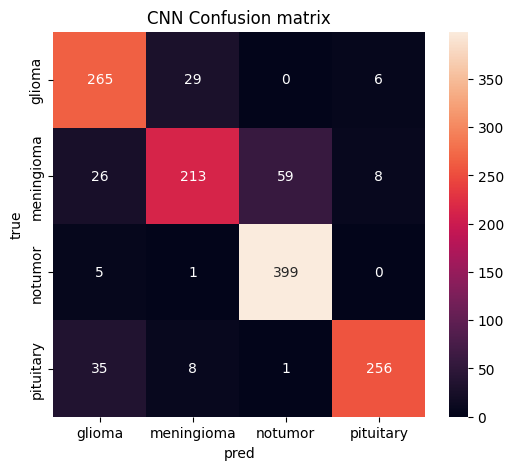

{'accuracy': 0.8642257818459191,
 'glioma': {'f1-score': 0.8399366085578447,
            'precision': 0.8006042296072508,
            'recall': 0.8833333333333333,
            'support': 300.0},
 'macro avg': {'f1-score': 0.8566512059574293,
               'precision': 0.866659750299069,
               'recall': 0.8544825708061002,
               'support': 1311.0},
 'meningioma': {'f1-score': 0.7648114901256733,
                'precision': 0.848605577689243,
                'recall': 0.696078431372549,
                'support': 306.0},
 'notumor': {'f1-score': 0.9236111111111112,
             'precision': 0.869281045751634,
             'recall': 0.9851851851851852,
             'support': 405.0},
 'pituitary': {'f1-score': 0.8982456140350877,
               'precision': 0.9481481481481482,
               'recall': 0.8533333333333334,
               'support': 300.0},
 'weighted avg': {'f1-score': 0.8615938083572354,
                  'precision': 0.8667870660785202,
               

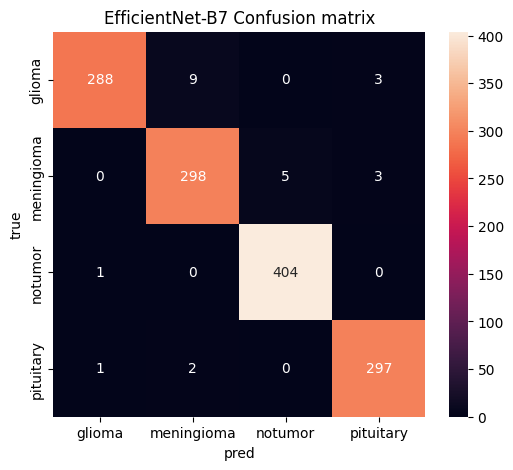

{'accuracy': 0.9816933638443935,
 'glioma': {'f1-score': 0.976271186440678,
            'precision': 0.993103448275862,
            'recall': 0.96,
            'support': 300.0},
 'macro avg': {'f1-score': 0.9807701242480631,
               'precision': 0.9813694559252296,
               'recall': 0.9803467683369644,
               'support': 1311.0},
 'meningioma': {'f1-score': 0.9691056910569106,
                'precision': 0.9644012944983819,
                'recall': 0.9738562091503268,
                'support': 306.0},
 'notumor': {'f1-score': 0.9926289926289926,
             'precision': 0.9877750611246944,
             'recall': 0.9975308641975309,
             'support': 405.0},
 'pituitary': {'f1-score': 0.9850746268656716,
               'precision': 0.9801980198019802,
               'recall': 0.99,
               'support': 300.0},
 'weighted avg': {'f1-score': 0.981666535064883,
                  'precision': 0.9818048331772378,
                  'recall': 0.981693363844

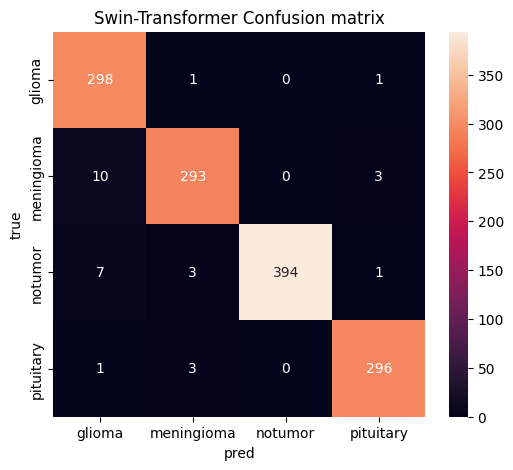

{'accuracy': 0.977116704805492,
 'glioma': {'f1-score': 0.9675324675324676,
            'precision': 0.9430379746835443,
            'recall': 0.9933333333333333,
            'support': 300.0},
 'macro avg': {'f1-score': 0.9764467291484582,
               'precision': 0.9757733364172869,
               'recall': 0.9775889615105302,
               'support': 1311.0},
 'meningioma': {'f1-score': 0.966996699669967,
                'precision': 0.9766666666666667,
                'recall': 0.9575163398692811,
                'support': 306.0},
 'notumor': {'f1-score': 0.986232790988736,
             'precision': 1.0,
             'recall': 0.9728395061728395,
             'support': 405.0},
 'pituitary': {'f1-score': 0.9850249584026622,
               'precision': 0.9833887043189369,
               'recall': 0.9866666666666667,
               'support': 300.0},
 'weighted avg': {'f1-score': 0.9771872602822175,
                  'precision': 0.9777177755154419,
                  'recall': 0

In [22]:
# Load eval JSON and display confusion matrices and reports
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

eval_dir = os.path.join(save_dir, "eval")
for fname in os.listdir(eval_dir):
    if not fname.endswith("_eval.json"): continue
    model_name = fname.replace("_eval.json","")
    with open(os.path.join(eval_dir,fname)) as f:
        obj = json.load(f)
    cm = np.array(obj["metrics"]["confusion_matrix"])
    print("\nModel:", model_name)
    print("Accuracy:", obj["metrics"]["accuracy"])
    # confusion
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.xlabel("pred"); plt.ylabel("true"); plt.title(f"{model_name} Confusion matrix")
    plt.show()
    # classification report (brief)
    from pprint import pprint
    pprint(obj["metrics"]["classification_report"])

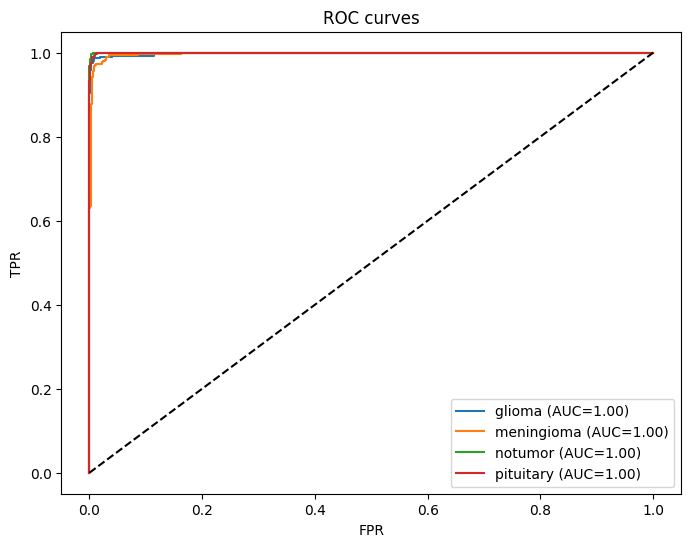

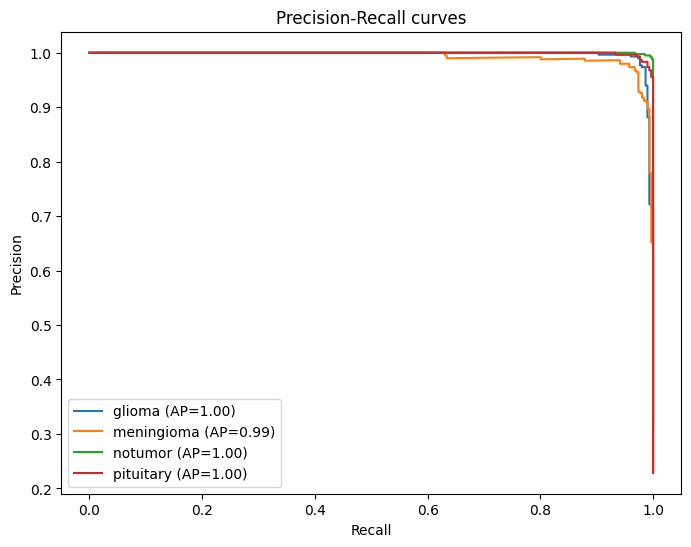

In [23]:
# ROC and PR per class for a chosen model (uses saved probs)
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# choose model evaluation file to plot (change if you want)
chosen = "EfficientNet-B7_eval.json"  # or CNN_eval.json / Swin-Transformer_eval.json
fpath = os.path.join(save_dir, "eval", chosen)
if not os.path.exists(fpath):
    print("Eval file not found:", fpath)
else:
    with open(fpath) as f:
        ev = json.load(f)
    y_true = np.array(ev["trues"])
    y_prob = np.array(ev["probs"])
    n_classes = len(classes)
    Y = label_binarize(y_true, classes=list(range(n_classes)))
    # ROC
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves"); plt.legend(); plt.show()
    # PR curves
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        prec, rec, _ = precision_recall_curve(Y[:,i], y_prob[:,i])
        ap = average_precision_score(Y[:,i], y_prob[:,i])
        plt.plot(rec, prec, label=f"{classes[i]} (AP={ap:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall curves"); plt.legend(); plt.show()

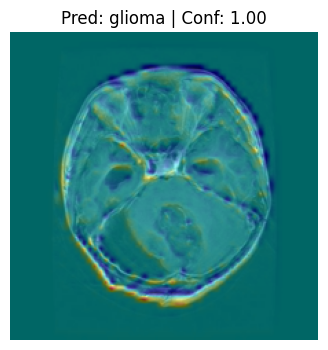

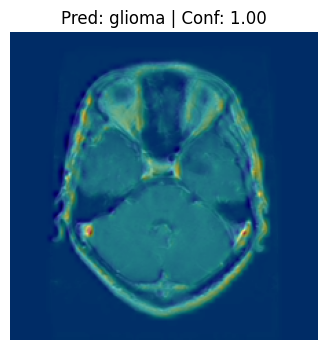

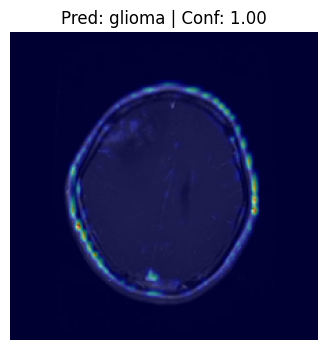

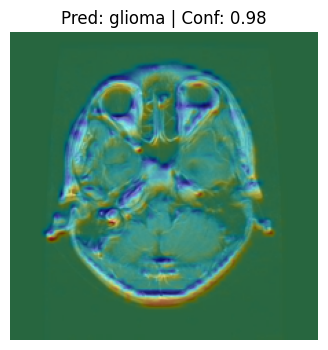

In [28]:
# Simple Grad-CAM implementation (works for CNN and timm models)
import torch, numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def find_last_conv(module):
    last = None
    for name, m in module.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last = (name, m)
    return last

def gradcam_for_image(model, img_path, transform, target_class=None, upsample_size=(224,224)):
    model.eval()
    # forward hook to capture activations
    name_conv, conv_mod = find_last_conv(model)
    if conv_mod is None:
        raise RuntimeError("No conv layer found for Grad-CAM")
    activations = {}
    def fhook(module, inp, out):
        out.retain_grad()  # ensure gradients available
        activations['feat'] = out
    hook = conv_mod.register_forward_hook(fhook)

    img_pil = Image.open(img_path).convert('RGB')
    img_t = transform(img_pil).unsqueeze(0).to(device)
    out = model(img_t)
    probs = torch.softmax(out, dim=1)
    pred = int(probs.argmax(dim=1).item())
    if target_class is None:
        target_class = pred

    score = out[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    feat = activations['feat']
    grad = feat.grad
    if grad is None:
        grad = torch.autograd.grad(score, feat, retain_graph=False)[0]

    weights = grad.mean(dim=(2,3), keepdim=True)
    cam = (weights * feat).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam.squeeze().detach().cpu().numpy()  # detach before numpy

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    cam = cv2.resize(cam, upsample_size)
    img_np = np.array(img_pil.resize(upsample_size))[:,:,::-1]
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = heatmap * 0.4 + img_np * 0.6
    hook.remove()
    return overlay[:, :, ::-1].astype(np.uint8), pred, float(probs[0, target_class].item())

# visualize a few test images
n_show = 4
indices = list(range(min(n_show, len(test_paths))))
for i in indices:
    overlay, pred, conf = gradcam_for_image(model, test_paths[i], val_transform)
    plt.figure(figsize=(4,4))
    plt.imshow(overlay)
    plt.title(f"Pred: {classes[pred]} | Conf: {conf:.2f}")
    plt.axis('off')
    plt.show()

Saved history for CNN -> /content/drive/MyDrive/BrainTumorProject/Models/CNN_history.json


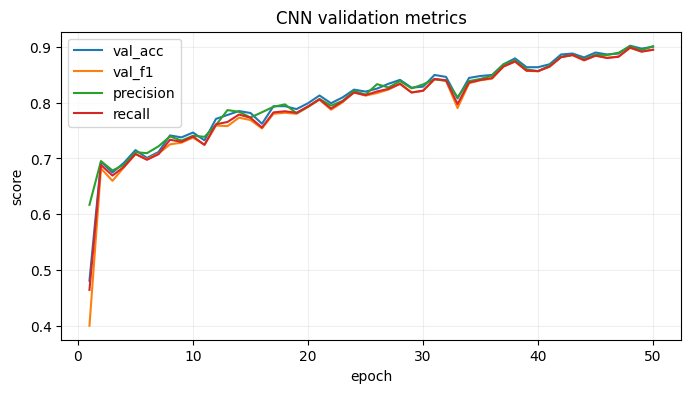

Saved plot -> /content/drive/MyDrive/BrainTumorProject/Models/CNN_history.png
Saved history for EfficientNet-B7 -> /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7_history.json


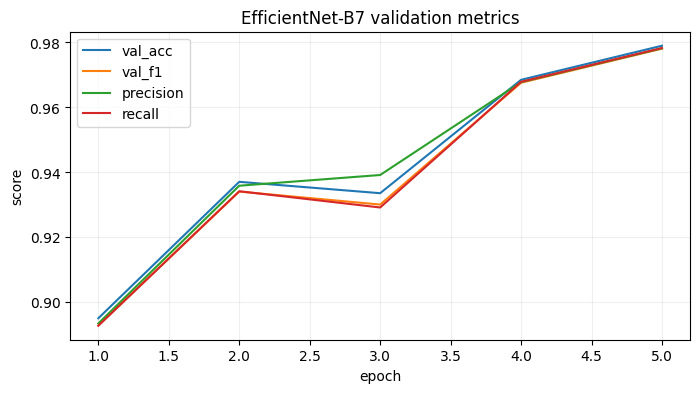

Saved plot -> /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7_history.png
Saved history for Swin-Transformer -> /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer_history.json


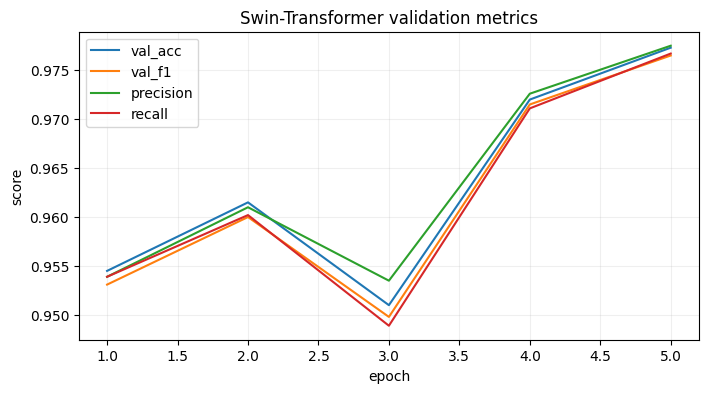

Saved plot -> /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer_history.png
Done parsing & plotting.


In [29]:
# Parse training logs, save history jsons, and plot curves
import re, os, json, matplotlib.pyplot as plt
from pathlib import Path

# paste your entire console output (all three model logs) here as a single string
log_text = r"""
===== Train CNN =====
Epoch [1/50] | Val Acc: 0.4808 | Prec: 0.6169 | Rec: 0.4644 | F1: 0.4002
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.4808)
Epoch [2/50] | Val Acc: 0.6941 | Prec: 0.6953 | Rec: 0.6883 | F1: 0.6822
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.6941)
Epoch [3/50] | Val Acc: 0.6748 | Prec: 0.6785 | Rec: 0.6694 | F1: 0.6599
Epoch [4/50] | Val Acc: 0.6923 | Prec: 0.6885 | Rec: 0.6850 | F1: 0.6842
Epoch [5/50] | Val Acc: 0.7150 | Prec: 0.7113 | Rec: 0.7080 | F1: 0.7081
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7150)
Epoch [6/50] | Val Acc: 0.7010 | Prec: 0.7095 | Rec: 0.6976 | F1: 0.6987
Epoch [7/50] | Val Acc: 0.7115 | Prec: 0.7217 | Rec: 0.7076 | F1: 0.7087
Epoch [8/50] | Val Acc: 0.7413 | Prec: 0.7395 | Rec: 0.7336 | F1: 0.7253
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7413)
Epoch [9/50] | Val Acc: 0.7378 | Prec: 0.7321 | Rec: 0.7298 | F1: 0.7283
Epoch [10/50] | Val Acc: 0.7465 | Prec: 0.7407 | Rec: 0.7393 | F1: 0.7374
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7465)
Epoch [11/50] | Val Acc: 0.7325 | Prec: 0.7388 | Rec: 0.7244 | F1: 0.7245
Epoch [12/50] | Val Acc: 0.7710 | Prec: 0.7599 | Rec: 0.7613 | F1: 0.7590
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7710)
Epoch [13/50] | Val Acc: 0.7780 | Prec: 0.7867 | Rec: 0.7654 | F1: 0.7580
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7780)
Epoch [14/50] | Val Acc: 0.7850 | Prec: 0.7837 | Rec: 0.7787 | F1: 0.7731
Epoch [15/50] | Val Acc: 0.7815 | Prec: 0.7735 | Rec: 0.7729 | F1: 0.7689
Epoch [16/50] | Val Acc: 0.7622 | Prec: 0.7829 | Rec: 0.7554 | F1: 0.7538
Epoch [17/50] | Val Acc: 0.7937 | Prec: 0.7927 | Rec: 0.7826 | F1: 0.7802
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7937)
Epoch [18/50] | Val Acc: 0.7937 | Prec: 0.7970 | Rec: 0.7846 | F1: 0.7819
Epoch [19/50] | Val Acc: 0.7885 | Prec: 0.7811 | Rec: 0.7819 | F1: 0.7801
Epoch [20/50] | Val Acc: 0.7990 | Prec: 0.7928 | Rec: 0.7933 | F1: 0.7922
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.7990)
Epoch [21/50] | Val Acc: 0.8129 | Prec: 0.8067 | Rec: 0.8060 | F1: 0.8054
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8129)
Epoch [22/50] | Val Acc: 0.7990 | Prec: 0.7947 | Rec: 0.7895 | F1: 0.7874
Epoch [23/50] | Val Acc: 0.8094 | Prec: 0.8031 | Rec: 0.8023 | F1: 0.8006
Epoch [24/50] | Val Acc: 0.8234 | Prec: 0.8212 | Rec: 0.8181 | F1: 0.8187
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8234)
Epoch [25/50] | Val Acc: 0.8199 | Prec: 0.8144 | Rec: 0.8135 | F1: 0.8127
Epoch [26/50] | Val Acc: 0.8252 | Prec: 0.8332 | Rec: 0.8201 | F1: 0.8172
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8252)
Epoch [27/50] | Val Acc: 0.8339 | Prec: 0.8273 | Rec: 0.8248 | F1: 0.8235
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8339)
Epoch [28/50] | Val Acc: 0.8409 | Prec: 0.8387 | Rec: 0.8338 | F1: 0.8338
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8409)
Epoch [29/50] | Val Acc: 0.8269 | Prec: 0.8257 | Rec: 0.8183 | F1: 0.8182
Epoch [30/50] | Val Acc: 0.8287 | Prec: 0.8327 | Rec: 0.8215 | F1: 0.8212
Epoch [31/50] | Val Acc: 0.8497 | Prec: 0.8421 | Rec: 0.8426 | F1: 0.8417
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8497)
Epoch [32/50] | Val Acc: 0.8462 | Prec: 0.8394 | Rec: 0.8401 | F1: 0.8393
Epoch [33/50] | Val Acc: 0.8077 | Prec: 0.8097 | Rec: 0.7976 | F1: 0.7904
Epoch [34/50] | Val Acc: 0.8444 | Prec: 0.8387 | Rec: 0.8360 | F1: 0.8350
Epoch [35/50] | Val Acc: 0.8479 | Prec: 0.8426 | Rec: 0.8407 | F1: 0.8403
Epoch [36/50] | Val Acc: 0.8497 | Prec: 0.8485 | Rec: 0.8441 | F1: 0.8430
Epoch [37/50] | Val Acc: 0.8689 | Prec: 0.8687 | Rec: 0.8649 | F1: 0.8652
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8689)
Epoch [38/50] | Val Acc: 0.8794 | Prec: 0.8759 | Rec: 0.8738 | F1: 0.8738
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8794)
Epoch [39/50] | Val Acc: 0.8636 | Prec: 0.8597 | Rec: 0.8575 | F1: 0.8570
Epoch [40/50] | Val Acc: 0.8636 | Prec: 0.8564 | Rec: 0.8567 | F1: 0.8563
Epoch [41/50] | Val Acc: 0.8689 | Prec: 0.8665 | Rec: 0.8645 | F1: 0.8650
Epoch [42/50] | Val Acc: 0.8864 | Prec: 0.8821 | Rec: 0.8816 | F1: 0.8817
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8864)
Epoch [43/50] | Val Acc: 0.8881 | Prec: 0.8859 | Rec: 0.8855 | F1: 0.8851
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8881)
Epoch [44/50] | Val Acc: 0.8811 | Prec: 0.8779 | Rec: 0.8761 | F1: 0.8759
Epoch [45/50] | Val Acc: 0.8899 | Prec: 0.8859 | Rec: 0.8842 | F1: 0.8847
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.8899)
Epoch [46/50] | Val Acc: 0.8864 | Prec: 0.8856 | Rec: 0.8802 | F1: 0.8803
Epoch [47/50] | Val Acc: 0.8881 | Prec: 0.8895 | Rec: 0.8823 | F1: 0.8828
Epoch [48/50] | Val Acc: 0.9021 | Prec: 0.9012 | Rec: 0.8988 | F1: 0.8982
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/CNN.pth (Acc: 0.9021)
Epoch [49/50] | Val Acc: 0.8969 | Prec: 0.8945 | Rec: 0.8914 | F1: 0.8920
Epoch [50/50] | Val Acc: 0.9003 | Prec: 0.9012 | Rec: 0.8949 | F1: 0.8949
Best accuracy for CNN: 0.9021
(0.9020979020979021,
 0.9012116404438953,
 0.8948806616822488,
 0.8949134190018064)



===== Train EfficientNet-B7 =====
Epoch [1/5] | Val Acc: 0.8951 | Prec: 0.8935 | Rec: 0.8928 | F1: 0.8929
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.8951)
Epoch [2/5] | Val Acc: 0.9371 | Prec: 0.9359 | Rec: 0.9342 | F1: 0.9341
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9371)
Epoch [3/5] | Val Acc: 0.9336 | Prec: 0.9392 | Rec: 0.9292 | F1: 0.9301
Epoch [4/5] | Val Acc: 0.9685 | Prec: 0.9678 | Rec: 0.9679 | F1: 0.9676
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9685)
Epoch [5/5] | Val Acc: 0.9790 | Prec: 0.9782 | Rec: 0.9783 | F1: 0.9781
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/EfficientNet-B7.pth (Acc: 0.9790)
Best accuracy for EfficientNet-B7: 0.9790
(0.9790209790209791,
 0.9781546853487256,
 0.9782938514154013,
 0.9781144080428386)


===== Train Swin-Transformer =====
Epoch [1/5] | Val Acc: 0.9545 | Prec: 0.9539 | Rec: 0.9539 | F1: 0.9531
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9545)
Epoch [2/5] | Val Acc: 0.9615 | Prec: 0.9610 | Rec: 0.9602 | F1: 0.9600
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9615)
Epoch [3/5] | Val Acc: 0.9510 | Prec: 0.9535 | Rec: 0.9489 | F1: 0.9498
Epoch [4/5] | Val Acc: 0.9720 | Prec: 0.9726 | Rec: 0.9711 | F1: 0.9715
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9720)
Epoch [5/5] | Val Acc: 0.9773 | Prec: 0.9775 | Rec: 0.9767 | F1: 0.9765
✅ Saved best model: /content/drive/MyDrive/BrainTumorProject/Models/Swin-Transformer.pth (Acc: 0.9773)
Best accuracy for Swin-Transformer: 0.9773
(0.9772727272727273,
 0.9775496477660691,
 0.9766557835820895,
 0.9764991046469296)
"""

# where to save
save_dir = "/content/drive/MyDrive/BrainTumorProject/Models"
Path(save_dir).mkdir(parents=True, exist_ok=True)

# regex to extract epoch metrics
epoch_re = re.compile(r'Epoch\s*\[(\d+)/\d+\]\s*\|\s*Val Acc:\s*([\d.]+)\s*\|\s*Prec:\s*([\d.]+)\s*\|\s*Rec:\s*([\d.]+)\s*\|\s*F1:\s*([\d.]+)', re.IGNORECASE)
# regex to capture model header
header_re = re.compile(r'^==+=+\s*Train\s*(.+?)\s*==+=+', re.MULTILINE)
# regex to capture saved-best lines with accuracy
saved_re = re.compile(r'Saved best model:.*\(Acc:\s*([\d.]+)\)', re.IGNORECASE)
best_re = re.compile(r'Best accuracy for\s*(.+?):\s*([\d.]+)', re.IGNORECASE)

# split log into model sections by header positions
sections = []
# find all header matches with span
headers = list(header_re.finditer(log_text))
if headers:
    for i, m in enumerate(headers):
        start = m.start()
        end = headers[i+1].start() if i+1 < len(headers) else len(log_text)
        sections.append((m.group(1).strip(), log_text[start:end]))
else:
    # fallback: treat whole text as one section named 'log'
    sections.append(('log', log_text))

parsed = {}
for name, sec in sections:
    epochs, accs, precs, recs, f1s = [], [], [], [], []
    best_per_epoch = {}
    for em in epoch_re.finditer(sec):
        e = int(em.group(1))
        epochs.append(e)
        accs.append(float(em.group(2)))
        precs.append(float(em.group(3)))
        recs.append(float(em.group(4)))
        f1s.append(float(em.group(5)))
    # find saved-best accuracies (in order)
    bests = [float(x.group(1)) for x in saved_re.finditer(sec)]
    # final Best accuracy line
    final_best = None
    m = best_re.search(sec)
    if m:
        final_best = float(m.group(2))
    parsed[name] = {
        "epochs": epochs,
        "val_acc": accs,
        "val_prec": precs,
        "val_rec": recs,
        "val_f1": f1s,
        "saved_bests": bests,
        "final_best": final_best
    }

# save and plot for each parsed model
for model_name, hist in parsed.items():
    if not hist["epochs"]:
        print("No epoch lines found for", model_name)
        continue
    out_path = os.path.join(save_dir, f"{model_name.replace(' ','_')}_history.json")
    with open(out_path, "w") as f:
        json.dump(hist, f, indent=2)
    print("Saved history for", model_name, "->", out_path)

    # plot
    ep = hist["epochs"]
    plt.figure(figsize=(8,4))
    plt.plot(ep, hist["val_acc"], label="val_acc")
    plt.plot(ep, hist["val_f1"], label="val_f1")
    plt.plot(ep, hist["val_prec"], label="precision")
    plt.plot(ep, hist["val_rec"], label="recall")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title(f"{model_name} validation metrics"); plt.legend()
    plt.grid(alpha=0.2)
    png = os.path.join(save_dir, f"{model_name.replace(' ','_')}_history.png")
    plt.savefig(png, bbox_inches="tight")
    plt.show()
    print("Saved plot ->", png)

print("Done parsing & plotting.")

In [30]:
import torch, json, os
from torchvision.datasets import ImageFolder

save_dir = "/content/drive/MyDrive/BrainTumorProject/Models"
train_dir = "/content/drive/MyDrive/BrainTumorProject/Data/Training"
os.makedirs(save_dir, exist_ok=True)

# save model
torch.save(model_effnet.to("cpu").state_dict(), os.path.join(save_dir, "EfficientNet-B7.pth"))

# save classes
try:
    classes = ImageFolder(train_dir).classes
except:
    classes = sorted(os.listdir(train_dir))
with open(os.path.join(save_dir, "classes.json"), "w") as f:
    json.dump(classes, f)

# save eval
eval_summary = {"model":"EfficientNet-B7","accuracy":0.9790,"precision":0.9782,"recall":0.9783,"f1_score":0.9781}
with open(os.path.join(save_dir, "eval_summary.json"), "w") as f:
    json.dump(eval_summary, f, indent=4)

# save deps
!pip freeze > "{os.path.join(save_dir, 'requirements.txt')}"
print("✅ Deployment files ready:", save_dir)

✅ Deployment files ready: /content/drive/MyDrive/BrainTumorProject/Models
